In [1]:
import pandas as pd 
import numpy as np 
%matplotlib inline
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb


In [2]:
data = pd.read_csv('Dados_da_carga.csv', encoding = 'utf-8',sep=';')
#selecao das colunas do excel
data = data.filter(regex=r'Regiao|w')


In [3]:
data


,Regiao,w0,w1,w2,w3,w4,w5,w6,w7,w8,...,w17,w18,w19,w20,w21,w22,w23,w24,w25,w26
0,1,43.231,41.038,40.694,39.387,40.650,37.688,40.928,39.572,38.564,...,35.221,34.463,34.295,34.007,34.751,35.246,31.881,33.234,33.632,34.161
1,2,11.040,11.130,11.138,11.341,11.347,11.337,11.232,11.307,10.669,...,10.645,10.389,10.074,9.773,9.656,9.962,9.966,9.820,9.535,9.724
2,3,5.462,5.402,5.507,5.591,5.498,5.289,5.428,5.646,5.374,...,5.616,5.605,5.568,5.372,5.323,5.442,5.347,5.360,5.362,5.342
3,4,14.058,12.366,12.593,12.197,12.049,12.197,11.585,11.366,11.357,...,10.461,10.369,10.733,10.546,10.709,10.760,10.534,10.642,10.683,10.671
4,5,73.791,69.936,69.932,68.516,69.544,66.511,69.173,67.891,65.964,...,61.943,60.826,60.670,59.698,60.439,61.410,57.728,59.056,59.212,59.898


In [4]:
melt = data.melt(id_vars = 'Regiao', var_name = 'week', value_name = 'carga')
melt['week'] = melt['week'].str.extract('(\d+)', expand = False).astype(int)
metl = melt.sort_values(['week'])
print(melt.shape)
melt.head()

(135, 3)


,Regiao,week,carga
0,1,0,43.231
1,2,0,11.040
2,3,0,5.462
3,4,0,14.058
4,5,0,73.791


In [5]:
melt2 = melt.copy()
melt2['carga_ultima_semana'] = melt2.groupby(['Regiao'])['carga'].shift()
melt2['Diff_carga_ultima_semana'] = melt2.groupby(['Regiao'])['carga_ultima_semana'].diff()
melt2 = melt2.dropna()
melt2.head()

,Regiao,week,carga,carga_ultima_semana,Diff_carga_ultima_semana
10,1,2,40.694,41.038,-2.193
11,2,2,11.138,11.130,0.090
12,3,2,5.507,5.402,-0.060
13,4,2,12.593,12.366,-1.692
14,5,2,69.932,69.936,-3.855


In [6]:
def rmsle(ytrue,ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))
    

In [7]:
mean_error = []
for week in range (18,26):
    train = melt2[melt['week'] < week]
    val = melt2[melt2['week'] == week]
    p = val['carga_ultima_semana'].values
    
    error = rmsle(val['carga'].values, p)
    print('week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

<ipython-input-7-cc04c3c28fb6>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train = melt2[melt['week'] < week]


week 18 - Error 0.01631
week 19 - Error 0.01919
week 20 - Error 0.02124
week 21 - Error 0.01389
week 22 - Error 0.01791
week 23 - Error 0.05251
week 24 - Error 0.02189
week 25 - Error 0.01316
Mean Error = 0.02201


<ipython-input-7-cc04c3c28fb6>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train = melt2[melt['week'] < week]
<ipython-input-7-cc04c3c28fb6>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train = melt2[melt['week'] < week]
<ipython-input-7-cc04c3c28fb6>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train = melt2[melt['week'] < week]
<ipython-input-7-cc04c3c28fb6>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train = melt2[melt['week'] < week]
<ipython-input-7-cc04c3c28fb6>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train = melt2[melt['week'] < week]
<ipython-input-7-cc04c3c28fb6>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train = melt2[melt['week'] < week]
<ipython-input-7-cc04c3c28fb6>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train 

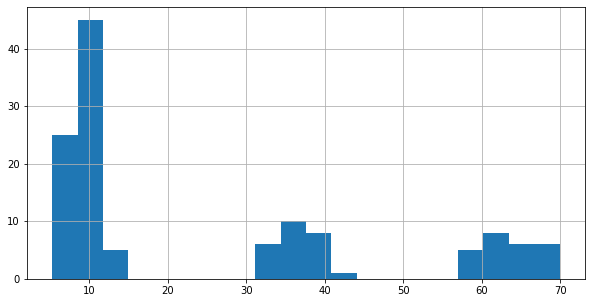

In [8]:
melt2['carga'].hist(bins=20, figsize=(10,5))

In [9]:
mean_error = []
for week in range(18,26):
    train = melt2[melt2['week'] < week]
    val = melt2[melt2['week'] == week]
    
    xtr, xts = train.drop(['carga'], axis=1), val.drop(['carga'], axis=1)
    ytr, yts = train['carga'].values, val['carga'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

week 18 - Error 0.02444
week 19 - Error 0.02381
week 20 - Error 0.02639
week 21 - Error 0.02061
week 22 - Error 0.01570
week 23 - Error 0.04748
week 24 - Error 0.00912
week 25 - Error 0.01545
Mean Error = 0.02287


In [10]:
melt3 = melt.copy()
melt3['carga_ultima_semana'] = melt3.groupby(['Regiao'])['carga'].shift()
melt3['Diff_carga_ultima_semana'] = melt3.groupby(['Regiao'])['carga_ultima_semana'].diff()
melt3['carga_ultima_semana-1'] = melt3.groupby(['Regiao'])['carga'].shift(2)
melt3['Diff_carga_ultima_semana-1'] = melt3.groupby(['Regiao'])['carga_ultima_semana-1'].diff()
melt3 = melt3.dropna()
melt3.head()

,Regiao,week,carga,carga_ultima_semana,Diff_carga_ultima_semana,carga_ultima_semana-1,Diff_carga_ultima_semana-1
15,1,3,39.387,40.694,-0.344,41.038,-2.193
16,2,3,11.341,11.138,0.008,11.130,0.090
17,3,3,5.591,5.507,0.105,5.402,-0.060
18,4,3,12.197,12.593,0.227,12.366,-1.692
19,5,3,68.516,69.932,-0.004,69.936,-3.855


In [11]:
mean_error = []
for week in range(18,26):
    train = melt3[melt3['week'] < week]
    val = melt3[melt3['week'] == week]
    
    xtr, xts = train.drop(['carga'], axis=1), val.drop(['carga'], axis=1)
    ytr, yts = train['carga'].values, val['carga'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

week 18 - Error 0.02541
week 19 - Error 0.02385
week 20 - Error 0.02829
week 21 - Error 0.02000
week 22 - Error 0.01667
week 23 - Error 0.04572
week 24 - Error 0.01056
week 25 - Error 0.01462
Mean Error = 0.02314


In [12]:
melt4 = melt.copy()
melt4['carga_ultima_semana'] = melt4.groupby(['Regiao'])['carga'].shift()
melt4['Diff_carga_ultima_semana'] = melt4.groupby(['Regiao'])['carga_ultima_semana'].diff()
melt4['carga_ultima_semana-1'] = melt4.groupby(['Regiao'])['carga'].shift(2)
melt4['Diff_carga_ultima_semana-1'] = melt4.groupby(['Regiao'])['carga_ultima_semana-1'].diff()
melt4['carga_ultima_semana-2'] = melt4.groupby(['Regiao'])['carga'].shift(3)
melt4['Diff_carga_ultima_semana-2'] = melt4.groupby(['Regiao'])['carga_ultima_semana-2'].diff()
melt4 = melt4.dropna()
melt4.head()

,Regiao,week,carga,carga_ultima_semana,Diff_carga_ultima_semana,carga_ultima_semana-1,Diff_carga_ultima_semana-1,carga_ultima_semana-2,Diff_carga_ultima_semana-2
20,1,4,40.650,39.387,-1.307,40.694,-0.344,41.038,-2.193
21,2,4,11.347,11.341,0.203,11.138,0.008,11.130,0.090
22,3,4,5.498,5.591,0.084,5.507,0.105,5.402,-0.060
23,4,4,12.049,12.197,-0.396,12.593,0.227,12.366,-1.692
24,5,4,69.544,68.516,-1.416,69.932,-0.004,69.936,-3.855


In [25]:
mean_error = []
for week in range(18,26):
    train = melt4[melt4['week'] < week]
    val = melt4[melt4['week'] >= week]
    
    xtr, xts = train.drop(['carga'], axis=1), val.drop(['carga'], axis=1)
    ytr, yts = train['carga'].values, val['carga'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 18 - Error 0.04701
Week 19 - Error 0.03953
Week 20 - Error 0.03760
Week 21 - Error 0.02920
Week 22 - Error 0.02643
Week 23 - Error 0.03029
Week 24 - Error 0.01867
Week 25 - Error 0.01747
Mean Error = 0.03078


In [23]:
val

,Regiao,week,carga,carga_ultima_semana,Diff_carga_ultima_semana,carga_ultima_semana-1,Diff_carga_ultima_semana-1,carga_ultima_semana-2,Diff_carga_ultima_semana-2
130,1,26,34.161,33.632,0.398,33.234,1.353,31.881,-3.365
131,2,26,9.724,9.535,-0.285,9.820,-0.146,9.966,0.004
132,3,26,5.342,5.362,0.002,5.360,0.013,5.347,-0.095
133,4,26,10.671,10.683,0.041,10.642,0.108,10.534,-0.226
134,5,26,59.898,59.212,0.156,59.056,1.328,57.728,-3.682


In [26]:
mean_error = []
for week in range(10,27):
    train = melt4[melt4['week'] < week]
    val = melt4[melt4['week'] >= week]
    
    xtr, xts = train.drop(['carga'], axis=1), val.drop(['carga'], axis=1)
    ytr, yts = train['carga'].values, val['carga'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 10 - Error 0.07397
Week 11 - Error 0.07594
Week 12 - Error 0.06492
Week 13 - Error 0.06266
Week 14 - Error 0.05829
Week 15 - Error 0.06337
Week 16 - Error 0.05891
Week 17 - Error 0.05066
Week 18 - Error 0.04656
Week 19 - Error 0.03914
Week 20 - Error 0.03728
Week 21 - Error 0.02859
Week 22 - Error 0.02580
Week 23 - Error 0.02985
Week 24 - Error 0.01733
Week 25 - Error 0.01745
Week 26 - Error 0.01631
Mean Error = 0.04512


In [27]:
p

array([33.01355988,  9.7438948 ,  5.38253164, 10.57571163, 59.23924707])

C:\Users\alexl\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\alexl\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


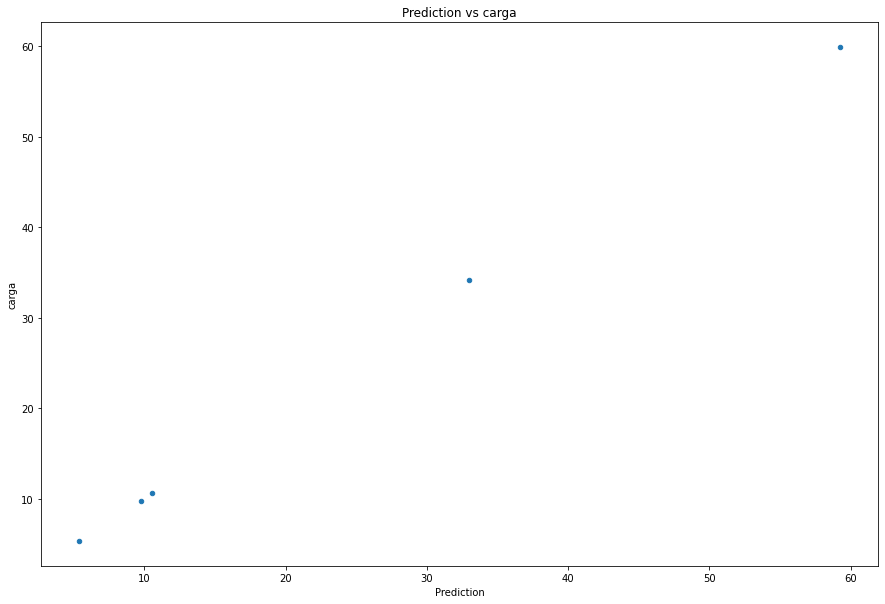

In [28]:
#colocando o array dentro do dataframe
val.loc[:, 'Prediction'] = p
val.plot.scatter(x='Prediction', y='carga', figsize=(15,10), title='Prediction vs carga')

In [29]:
val

,Regiao,week,carga,carga_ultima_semana,Diff_carga_ultima_semana,carga_ultima_semana-1,Diff_carga_ultima_semana-1,carga_ultima_semana-2,Diff_carga_ultima_semana-2,Prediction
130,1,26,34.161,33.632,0.398,33.234,1.353,31.881,-3.365,33.013560
131,2,26,9.724,9.535,-0.285,9.820,-0.146,9.966,0.004,9.743895
132,3,26,5.342,5.362,0.002,5.360,0.013,5.347,-0.095,5.382532
133,4,26,10.671,10.683,0.041,10.642,0.108,10.534,-0.226,10.575712
134,5,26,59.898,59.212,0.156,59.056,1.328,57.728,-3.682,59.239247


In [18]:
melt4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 20 to 134
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Regiao                      115 non-null    int64  
 1   week                        115 non-null    int32  
 2   carga                       115 non-null    float64
 3   carga_ultima_semana         115 non-null    float64
 4   Diff_carga_ultima_semana    115 non-null    float64
 5   carga_ultima_semana-1       115 non-null    float64
 6   Diff_carga_ultima_semana-1  115 non-null    float64
 7   carga_ultima_semana-2       115 non-null    float64
 8   Diff_carga_ultima_semana-2  115 non-null    float64
dtypes: float64(7), int32(1), int64(1)
memory usage: 8.5 KB
